# Imports

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns

#interactive plotting in separate window
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
# %matplotlib qt

from mpl_toolkits import mplot3d
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
from matplotlib.figure import Figure
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

from copy import deepcopy

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication
import datetime as dt

import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
pn.extension()
# pn.extension('tabulator')



In [5]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

# import neuropy.core as core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch
from neuropy.core.epoch import NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable
from neuropy.plotting import plot_raster
from neuropy.analyses.placefields import PlacefieldComputationParameters

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [6]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences


from PendingNotebookCode import debug_print_spike_counts, compute_placefields_as_needed, build_configs, build_units_colormap, build_placefield_multiplotter, process_by_good_placefields

# Load Session Data

In [7]:
# KDiba Old Format:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
# 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
sess = DataSessionLoader.kdiba_old_format_session(basedir)
active_sess_config = sess.config
session_name = sess.name

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat...
done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session...
curr_active_epoch_timeslice_indicies: Int64Index([   27,    28,    29,    30,    31,    32,    33,    34,    35,
               36,
            ...
            52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147,
            52148],
           dtype='int64', length=52122)
 	 np.shape(curr_active_epoch_timeslice_indicies): (52122,)
curr_active_epoch_timeslice_indicies: Int64Index([52149, 52150, 52151, 52152, 52153, 52154, 52155, 52156, 52157,


In [30]:
# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\n session.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))

# np.unique(sess.spikes_df.traj) # array([ 0,  1,  2,  3,  4,  7, 11, 12, 13, 14])
# traj_grouped_spikes_df = sess.spikes_df.groupby(['traj']) #  as_index=False keeps the original index

# This is useless, because traj are repeated.
# traj_grouped_spikes_df.first()['t_rel_seconds']
# traj_grouped_spikes_df.last()['t_rel_seconds']

In [ ]:
sess.laps

In [159]:
def partition(df: pd.DataFrame, partitionColumn: str):
    # splits a DataFrame df on the unique values of a specified column (partitionColumn) to return a unique DataFrame for each unique value in the column.
    unique_values = np.unique(df[partitionColumn]) # array([ 0,  1,  2,  3,  4,  7, 11, 12, 13, 14])
    grouped_df = df.groupby([partitionColumn]) #  Groups on the specified column.
    return unique_values, np.array([grouped_df.get_group(aValue) for aValue in unique_values], dtype=object) # dataframes split for each unique value in the column


unique_traj_values, traj_grouped_spikes_dfs = partition(sess.spikes_df, 'traj')
unique_lap_values, lap_grouped_spikes_dfs = partition(sess.spikes_df, 'lap')

unique_lap_values
np.unique(lap_grouped_spikes_dfs[1].traj)

[np.unique(aLapDf.traj) for aLapDf in lap_grouped_spikes_dfs] # gets the unique traj values for each lap's dataframe.

lap_grouped_spikes_dfs[1]

,t,t_seconds,t_rel_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,cell_type,flat_spike_idx,x_loaded,y_loaded,lin_pos,unit_id
15841,960589.0,506947.145328,29.509279,3,8,30,5,233.707482,145.070597,8.197582,7,1,1,1,NeuronType.CONTAMINATED,15841,0.828640,0.502664,-51.256627,28
15842,960625.0,506947.146434,29.510385,11,5,59,5,233.702922,145.062750,8.199499,7,1,1,1,NeuronType.CONTAMINATED,15842,0.828639,0.502657,-51.250145,57
15843,960789.0,506947.151472,29.515423,11,6,60,5,233.682148,145.027001,8.208233,7,1,1,1,NeuronType.CONTAMINATED,15843,0.828592,0.502634,-51.220617,58
15844,960795.0,506947.151656,29.515607,8,8,50,5,233.681388,145.025694,8.208552,7,1,1,1,NeuronType.CONTAMINATED,15844,0.828590,0.502634,-51.219537,48
15845,960814.0,506947.152240,29.516191,3,8,30,5,233.678981,145.021552,8.209564,7,1,1,1,NeuronType.CONTAMINATED,15845,0.828582,0.502632,-51.216116,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25893,1551021.0,506965.283390,47.647341,8,8,50,5,55.168523,141.758784,6.316042,4,1,1,1,NeuronType.CONTAMINATED,25893,0.195242,0.491704,127.264764,48
25894,1551236.0,506965.289995,47.653946,11,6,60,5,55.132727,141.736207,6.313757,4,1,1,1,NeuronType.CONTAMINATED,25894,0.195189,0.491519,127.302360,58
25895,1551297.0,506965.291868,47.655819,2,7,15,5,55.122571,141.729801,6.313109,4,1,1,1,NeuronType.CONTAMINATED,25895,0.195179,0.491466,127.313027,13
25896,1551313.0,506965.292360,47.656311,4,4,35,5,55.119907,141.728121,6.312939,4,1,1,1,NeuronType.CONTAMINATED,25896,0.195177,0.491453,127.315824,33


In [160]:
## Testing Filtering out bad traj values in laps
good_traj_only_lap_grouped_spikes_dfs = [aLapDf[aLapDf.traj != 7] for aLapDf in lap_grouped_spikes_dfs] # excludes the bad traj values for each lap's dataframe.
[np.unique(aLapDf.traj) for aLapDf in good_traj_only_lap_grouped_spikes_dfs] # gets the unique traj values for each lap's dataframe.
good_traj_only_lap_grouped_spikes_dfs[1]

,t,t_seconds,t_rel_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,cell_type,flat_spike_idx,x_loaded,y_loaded,lin_pos,unit_id
15897,964572.0,506947.267686,29.631637,1,9,6,5,232.900475,144.146421,14.105928,4,1,1,1,NeuronType.CONTAMINATED,15897,0.821744,0.501087,-50.074583,4
15898,964600.0,506947.268546,29.632497,7,5,41,5,232.889435,144.139093,14.250852,4,1,1,1,NeuronType.CONTAMINATED,15898,0.821662,0.501058,-50.061729,39
15899,964615.0,506947.269007,29.632958,8,14,54,5,232.883521,144.135167,14.328490,4,1,1,1,NeuronType.CONTAMINATED,15899,0.821617,0.501043,-50.054842,52
15900,964624.0,506947.269283,29.633234,2,7,15,5,232.879973,144.132812,14.375073,4,1,1,1,NeuronType.CONTAMINATED,15900,0.821591,0.501033,-50.050710,13
15901,964641.0,506947.269805,29.633756,4,4,35,5,232.873270,144.128363,14.463062,4,1,1,1,NeuronType.CONTAMINATED,15901,0.821541,0.501016,-50.042906,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25893,1551021.0,506965.283390,47.647341,8,8,50,5,55.168523,141.758784,6.316042,4,1,1,1,NeuronType.CONTAMINATED,25893,0.195242,0.491704,127.264764,48
25894,1551236.0,506965.289995,47.653946,11,6,60,5,55.132727,141.736207,6.313757,4,1,1,1,NeuronType.CONTAMINATED,25894,0.195189,0.491519,127.302360,58
25895,1551297.0,506965.291868,47.655819,2,7,15,5,55.122571,141.729801,6.313109,4,1,1,1,NeuronType.CONTAMINATED,25895,0.195179,0.491466,127.313027,13
25896,1551313.0,506965.292360,47.656311,4,4,35,5,55.119907,141.728121,6.312939,4,1,1,1,NeuronType.CONTAMINATED,25896,0.195177,0.491453,127.315824,33


In [ ]:
def get_lap_start_stop_indicies(lap_grouped_spikes_dfs):
    test_start_lap_indicies = [aLapDf.t_rel_seconds.values[0] for aLapDf in lap_grouped_spikes_dfs] # exclude the first entry, which is correspondant to the -1 lap
    test_end_lap_indicies = [aLapDf.t_rel_seconds.values[-1] for aLapDf in lap_grouped_spikes_dfs] # exclude the first entry, which is correspondant to the -1 lap
    return test_start_lap_indicies, test_end_lap_indicies

# get_lap_start_stop_indicies(lap_grouped_spikes_dfs)
start_lap_indicies, end_lap_indicies = get_lap_start_stop_indicies(lap_grouped_spikes_dfs)
start_lap_indicies_good_only, end_lap_indicies_good_only = get_lap_start_stop_indicies(good_traj_only_lap_grouped_spikes_dfs)

test_new_laps_df = pd.DataFrame({'lap_id':unique_lap_values[1:-1], 'start':start_lap_indicies_good_only[1:-1], 'end':end_lap_indicies_good_only[1:-1], 'start_all':start_lap_indicies[1:-1], 'end_all':end_lap_indicies[1:-1]})
test_new_laps_df

In [ ]:
lap_specific_subsessions = list()
lap_grouped_spikes_df = sess.spikes_df.groupby(['lap']) #  as_index=False keeps the original index

In [ ]:
i = 2
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))
# lap_specific_subsessions.append(sess.time_slice(curr_lap_dataframe.t_seconds.values[0], curr_lap_dataframe.t_seconds.values[-1]))

In [ ]:
i = 3
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))

In [ ]:
lap_specific_session = DataSession.concat(lap_specific_subsessions)
lap_specific_session

In [ ]:
lap_specific_session.neurons.n_spikes # this looks right.

lap_specific_session.position.print_debug_str() # this looks right.

# len(sess.neurons.n_spikes) # 64 items long
# sess.neurons.n_spikes
# array([ 1707,  1359,   554,  3066, 91337,  2707,   294,  2991,   913,
#         1278,  1221,  5475,  2880, 36760, 48449,   523,  2595,  3025,
#        34729,  3958,  5263,   790,   663,  1070,  1078,  2954,  4044,
#         2581, 73951,  4871, 13444,   476,  1234, 89854,  5822, 14961,
#         2682,  1184, 13575, 83972,   795, 22769,  1559,  8307,  2098,
#          438,  3476, 28370, 43854,  1355,  2552,  2875, 59011,  1440,
#        75786,  3656,   875, 17727, 77247,   550,   408,  2627,  1734,
#         2799])



## Laps: Create version of Session that only includes activity during the laps

In [ ]:
lap_specific_epochs = sess.laps.as_epoch_obj()
# lap_specific_epochs.to_dataframe()
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(sess.laps.lap_id), 2)])
# odd_lap_specific_epochs

# even_lap_specific_session = [lap_specific_sessions[i] for i in np.arange(0, len(sess.laps.lap_id), 2)]
# odd_lap_specific_session = [lap_specific_sessions[i] for i in np.arange(1, len(lap_specific_sessions), 2)]
# even_lap_specific_session
# range(0, 2, len(lap_specific_sessions))

### Lap Specific Session Debugging

In [116]:
# velocity = np.insert(np.diff(sess.position.x), 0, 0) / np.insert(np.diff(sess.position.time), 0, 0)
# acceleration = np.insert(np.diff(velocity), 0, 0) / np.insert(np.diff(sess.position.time), 0, 0)
# acceleration


updated_pos_df = deepcopy(sess.position.compute_higher_order_derivatives())
# updated_pos_df['velocity'] = updated_pos_df[['velocity_x', 'velocity_y']].to_numpy()
# updated_pos_df
# updated_pos_df.columns # ['t', 'x', 'y', 'lin_pos', 'speed', 'lap', 'lap_dir', 'dt', 'velocity_x', 'acceleration_x', 'velocity_y', 'acceleration_y']



# new_columns = pd.MultiIndex.from_tuples([('t'), ('x'), ('y'), ('lin_pos'), ('speed'), ('lap'), ('lap_dir'), ('dt'), ('velocity_x','velocity_y'), ('acceleration_x', 'acceleration_y')])
# new_columns
# updated_pos_df.columns = pd.MultiIndex.from_tuples([(c[0], c[1]) for c in updated_pos_df.columns])


# pos_obj = sess.position
# pos_obj.ndim
# pos_obj.dim_columns
# pos_df = pos_obj.to_dataframe()
# # pos_times = pos_obj.time
# updated_pos_df = deepcopy(pos_df)

# for dim_i in np.arange(pos_obj.ndim):
#     curr_column_label = pos_obj.dim_columns[dim_i]
#     updated_pos_df = Position.perform_compute_higher_order_derivatives(updated_pos_df, curr_column_label)
    
# # sess.position.to_dataframe

# # updated_pos_df = Position.perform_compute_higher_order_derivatives(pos_df, 'x')
# # updated_pos_df = Position.perform_compute_higher_order_derivatives(updated_pos_df, 'y')

# updated_pos_df

array([58.504551165679004, 67.77854577742983], dtype=object)

# Filter Session by Epoch:

In [15]:
sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# sess.epochs.to_dataframe()
active_epoch = sess.epochs.get_named_timerange('maze1')
# print('active_epoch: {}'.format(active_epoch))
# active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])
active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)

## All Spikes:
active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
# print(sess.neurons.n_spikes)

# # ## Lap_specific Spikes Only:
# active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
# print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)
# # print(active_lap_specific_epoch_session.neurons.n_spikes)

## Configure Placefield Calc:
should_display_2D_plots = True

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2, smooth=0.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=10, smooth=0.5, frate_thresh=2.0) # works well
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2.5, smooth=1.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.5, 0.5), frate_thresh=0.0)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.1, grid_bin=(3, 4), smooth=(2, 1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 10), smooth=(0.5, 0.5), frate_thresh=2.0) ## Works well for 2D Placemaps
# height: 20.0
# width: 250.0
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 0.2), smooth=(0.5, 0.5), frate_thresh=2.0) ## Extremely Slow
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 1.0), smooth=(0.5, 0.5), frate_thresh=2.0) ## Very slow, doesn't work

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.1, 0.1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(1.0, 10.0), frate_thresh=2.0)

# active_config.computation_config.frate_thresh = 0.0

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1739.1533641185379)
69142/932598 total spikes spanning 40/64 units remain in subsession


## Compute Placefields if needed:

In [ ]:
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
# active_config.computation_config.smooth = (1.5, 0.5)
active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_epoch_session, active_config.computation_config, active_config, active_epoch_placefields1D, active_epoch_placefields2D, included_epochs=None, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the updated session using the units that have good placefields
active_epoch_session, active_config, good_placefield_neuronIDs = process_by_good_placefields(active_epoch_session, active_config, active_epoch_placefields)
debug_print_spike_counts(active_epoch_session)

## Compute the placefields for lap-only filtered Session:

# Pho Custom Placefield2D Implementation:


In [ ]:
from neuropy.analyses.placefields import _bin_pos, plot_placefield_occupancy, plot_occupancy_custom, _filter_by_frate, Pf2D, _normalized_occupancy

from neuropy.core.ratemap import Ratemap

# First, interested in answering the question "where did the animal spend its time on the track" to assess the relative frequency of events that occur in a given region. If the animal spends a lot of time in a certain region,
# it's more likely that any cell, not just the ones that hold it as a valid place field, will fire there.
    # this can be done by either binning (lumping close position points together based on a standardized grid), neighborhooding, or continuous smearing. 

def build_customPf2D_fromConfig(active_epoch_session, custom_computation_config):
    # num_bins = (10, 10)
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots(2, 1)
    
    should_plot_multiple_occupancy_curves = False
    
    pos_df = active_epoch_session.position.to_dataframe().copy()
    laps_df = active_epoch_session.laps.to_dataframe().copy()
    spk_df = active_epoch_session.spikes_df.copy()

    ## Binning with Fixed Number of Bins:    
    xbin, ybin, bin_info = _bin_pos(pos_df.x.to_numpy(), pos_df.y.to_numpy(), bin_size=custom_computation_config.grid_bin) # bin_size mode
    # print(bin_info)
    ## Binning with Fixed Bin Sizes:
    # xbin, ybin, bin_info = _bin_pos(pos_df.x.to_numpy(), pos_df.y.to_numpy(), num_bins=num_bins) # num_bins mode
    # print(bin_info)

    # print('xbin: {}'.format(xbin))
    # print('ybin: {}'.format(ybin))

    # # Laps plotting:
    # # pos_df.lin_pos.plot();
    # curr_lap_id = 3
    # plt.plot(pos_df.t, pos_df.lin_pos, '*');
    # plt.xlim([laps_df.start[curr_lap_id], laps_df.stop[curr_lap_id]])
    # # pos_df.describe()
    # # pos_df.boxplot()

    raw_occupancy, xedges, yedges = Pf2D._compute_occupancy(pos_df.x.to_numpy(), pos_df.y.to_numpy(), xbin, ybin, active_epoch_session.position.sampling_rate, custom_computation_config.smooth, should_return_raw_occupancy=True)
    seconds_occupancy, normalized_occupancy = _normalized_occupancy(raw_occupancy, position_srate=active_epoch_session.position.sampling_rate)
    occupancy = seconds_occupancy
    # print(np.shape(occupancy))
    # print(occupancy)
    # plot_occupancy(occupancy)
    # plot_occupancy_custom(active_epoch_placefields2D)

    if should_plot_multiple_occupancy_curves:
        fig, ax = plot_occupancy_custom(raw_occupancy, xedges, yedges, max_normalized=False)
        ax.set_title('Custom Occupancy: Raw')
        fig, ax = plot_occupancy_custom(normalized_occupancy, xedges, yedges, max_normalized=False)
        ax.set_title('Custom Occupancy: Normalized')
        fig, ax = plot_occupancy_custom(seconds_occupancy, xedges, yedges, max_normalized=False)
        ax.set_title('Custom Occupancy: Seconds')

    # pos_df.groupby('lap').plas.hist(alpha=0.4)

    # Given a cell's last several seconds of its instantaneous firing rate at a given point in time, what's like likelihood that it's at a given position.
        # continuous position used.

    # spk_df_filtered_speed_thresh = spk_df[spk_df['speed'] >= custom_computation_config.speed_thresh].copy() # filter out the spikes below the speed_threshold
    # spk_x = spk_df_filtered_speed_thresh['x'].to_numpy()
    # spk_y = spk_df_filtered_speed_thresh['y'].to_numpy()

    spk_x = spk_df['x'].to_numpy()
    spk_y = spk_df['y'].to_numpy()
    num_spike_counts_map = Pf2D._compute_tuning_map(spk_x, spk_y, xbin, ybin, occupancy, custom_computation_config.smooth, should_return_raw_tuning_map=True)
    fig, ax[0] = plot_occupancy_custom(num_spike_counts_map, xbin, ybin, max_normalized=False, fig=fig, ax=ax[0])
    ax[0].set_title('Custom num_spike_counts_map: All Neurons')

    mpl_pane = pn.pane.Matplotlib(fig, dpi=144, height=800)
    tabs = pn.Tabs(('num_spike_counts_map', fig))
    ## This seems to be wrong, the highest spike rate is like 0.1 (in Hz)
    spike_rate_Hz_map = num_spike_counts_map / seconds_occupancy
    fig, ax[1] = plot_occupancy_custom(spike_rate_Hz_map, xbin, ybin, max_normalized=False, fig=fig, ax=ax[1])
    ax[1].set_title('Custom spike_rate_Hz_map [Hz]: All Neurons, Occupancy Divided')
    # Add a tab
    tabs.append(('spike_rate_Hz_map', fig))

    # # Add a tab
    # tabs.append(('Slider', pn.widgets.FloatSlider()))

    neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
    raw_tuning_maps = np.asarray([Pf2D._compute_tuning_map(neuron_split_spike_dfs[i].x.to_numpy(), neuron_split_spike_dfs[i].y.to_numpy(), xbin, ybin, occupancy, custom_computation_config.smooth, should_return_raw_tuning_map=True) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
    tuning_maps = np.asarray([raw_tuning_maps[i] / occupancy for i in np.arange(len(raw_tuning_maps))])
    ratemap = Ratemap(tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=active_epoch_session.neuron_ids)

    # fig, ax = plot_occupancy_custom(raw_tuning_maps[0], xedges, yedges, max_normalized=False)
    # ax.set_title('Custom raw_tuning_maps: Seconds')
    firing_spike_counts_max = np.asarray([np.nanmax(raw_tuning_maps[i]) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
    # print('firing_spike_counts_max: {}'.format(firing_spike_counts_max))
    firing_rate_max = np.asarray([np.nanmax(tuning_maps[i]) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
    # print('firing_rate_max: {}'.format(firing_rate_max))

    filtered_tuning_maps, filter_function = _filter_by_frate(tuning_maps.copy(), custom_computation_config.frate_thresh)
    filtered_ratemap = Ratemap(filtered_tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=filter_function(ratemap.neuron_ids))
    
    # outputs: filtered_ratemap, filtered_ratemap
    
    # plt.fastcolor(active_epoch_placefields1D.occupancy)
    # Convolve the location data

    # plot_occupancy(active_epoch_placefields2D)
    # pn.pane.Matplotlib(fig)
    
    return fig

def build_customPf2D(active_epoch_session, speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=0.0):
    # custom_active_config = active_config
    # note the second smoothing paramter affects the horizontal axis on the occupancy plot:
    # custom_computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(2, 0.1), frate_thresh=0.0)
    # custom_computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=0.0)
    custom_computation_config = PlacefieldComputationParameters(speed_thresh=speed_thresh, grid_bin=grid_bin, smooth=smooth, frate_thresh=frate_thresh)
    return build_customPf2D_fromConfig(active_epoch_session, custom_computation_config)

def build_customPf2D_separate(active_epoch_session, speed_thresh=1, grid_bin_x=10, grid_bin_y=3, smooth_x=0.0, smooth_y=0.0, frate_thresh=0.0):
    return build_customPf2D(active_epoch_session, speed_thresh=speed_thresh, grid_bin=(grid_bin_x, grid_bin_y), smooth=(smooth_x, smooth_y), frate_thresh=frate_thresh)


# build_customPf2D(active_epoch_session, speed_thresh=1, grid_bin=10, smooth=0.0, frate_thresh=0.0)
# pn.interact(build_customPf2D, active_epoch_session=fixed(active_epoch_session), speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
pn.interact(build_customPf2D_separate, active_epoch_session=fixed(active_epoch_session), speed_thresh=(0.0, 20.0, 1.0), grid_bin_x=(0.10, 20.0, 0.5), grid_bin_y=(0.10, 20.0, 0.5), smooth_x=(0.0, 20.0, 0.25), smooth_y=(0.0, 20.0, 0.25), frate_thresh=(0.0, 20.0, 1.0))

In [ ]:
# print(np.unique(spk_df['aclu']))
# print(np.unique(spk_df['unit_id']))

curr_unit_idx = 3
def plot_ratemap(curr_unit_idx = 3):
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots()
    mesh_X, mesh_Y = np.meshgrid(ratemap.xbin, ratemap.ybin)
    pfmap = ratemap.tuning_curves[curr_unit_idx]
    curr_pfmap = np.array(pfmap)
    curr_pfmap = np.rot90(np.fliplr(curr_pfmap)) / np.nanmax(curr_pfmap)
    ax.pcolormesh(mesh_X, mesh_Y, curr_pfmap, cmap='jet', vmin=0);
    ax.set_title(f'TuningCurve[{curr_unit_idx}]')
    pn.pane.Matplotlib(fig)
    return fig

# plot_ratemap(5)
# pn.interact(plot_ratemap, curr_unit_idx=3)
pn.interact(plot_ratemap, curr_unit_idx=widgets.IntSlider(start=0,end=ratemap.n_neurons,step=1,value=10))



## Main Spike/Placemap plotting:

# 2D Lap Plotting

### 2D Lap Trajectories Visualization:

## 2D Placefield Plotting:

In [ ]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
from PhoPositionalData.plotting.placefield import plot_1d_placecell_validations
# out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, should_save=True, save_mode='pdf')
out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, should_save=True, save_mode='separate_files')
# plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, modifier_string='lap_only', should_save=False)

NameError: name 't_even' is not defined

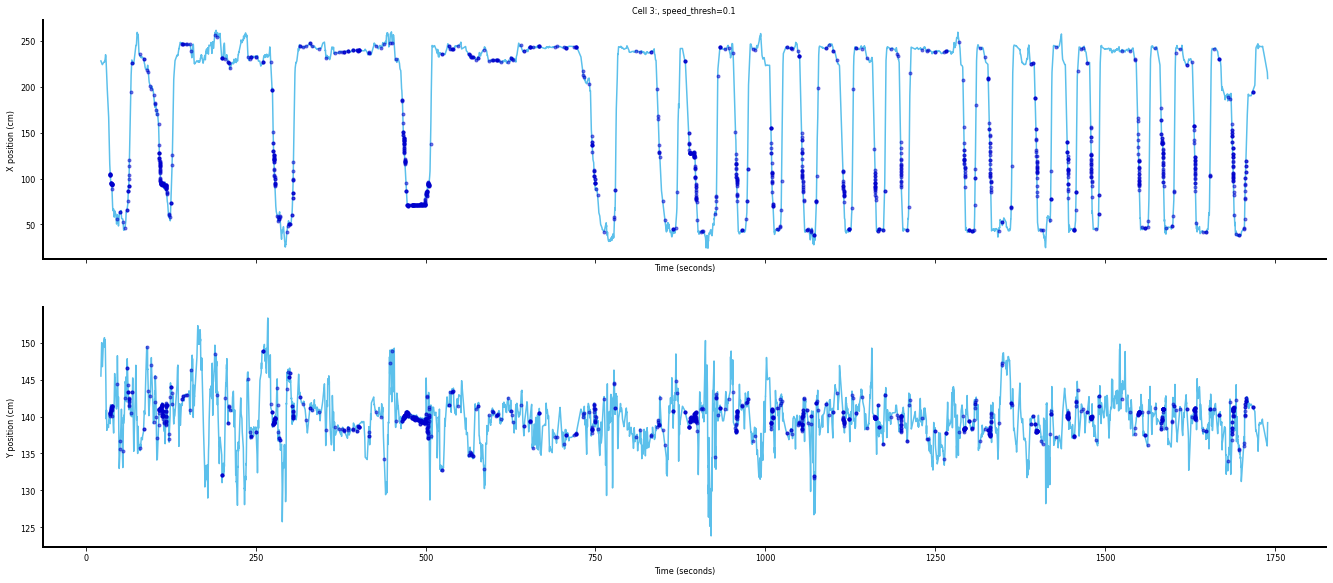

In [50]:
# active_epoch_placefields2D.plotRaw()
curr_cell_id = 1
fig, ax = active_epoch_placefields2D.plotRaw_v_time(curr_cell_id)
# ax[0].plot(t_both, x_both, 'k', alpha=0.8, linewidth=5)
ax[0].plot(t_even, x_even, 'g', alpha=0.3, linewidth=3)
ax[0].plot(t_odd, x_odd, 'r', alpha=0.3, linewidth=3)

In [123]:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.to_dataframe()
pos_df

,t,x,y,lin_pos,speed,lap,lap_dir,dt,velocity_x,acceleration_x,velocity_y,acceleration_y
0,-0.888858,104.287278,100.981569,NaN,0.000000,NaN,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.855297,104.287278,100.981569,NaN,0.000000,NaN,-1.0,0.033561,0.000000,0.000000,0.000000,0.000000
2,-0.822507,104.287278,100.981569,NaN,0.000000,NaN,-1.0,0.032790,0.000000,0.000000,0.000000,0.000000
3,-0.789218,104.287278,100.981569,NaN,0.000000,NaN,-1.0,0.033289,0.000000,0.000000,0.000000,0.000000
4,-0.755506,104.287278,100.981569,NaN,0.000000,NaN,-1.0,0.033712,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
59303,1977.872279,75.767781,140.059733,NaN,2.439347,44.0,0.0,0.033771,-2.370265,10.481742,-0.436719,46.572345
59304,1977.905486,75.766816,140.106978,NaN,1.416224,44.0,0.0,0.033207,-0.029054,70.503547,1.422749,55.996259
59305,1977.940449,75.735555,140.106496,NaN,0.936994,44.0,0.0,0.034963,-0.894114,-24.742152,-0.013802,-41.087763
59306,1977.971852,75.593275,140.042007,NaN,4.681661,44.0,0.0,0.031403,-4.530791,-115.806658,-2.053567,-64.954447


In [162]:
# For Gradient Line Plotting:
import matplotlib.collections as mcoll

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    num_points = np.shape(x)[0]
    points = np.array([x, y]).T.reshape(-1, num_points, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

# pos_df should already have the 'lap' column, so this should be easy:
good_pos_df = pos_df[np.logical_not(np.isnan(pos_df.lap))] # pre-filter for non-NaN laps. Throws an error otherwise.
unique_lap_values, lap_grouped_pos_dfs = partition(good_pos_df, 'lap') # split position dataframe based on its lap number
lap_num_points = [np.shape(a_df) for a_df in lap_grouped_pos_dfs]
# lap_points = [a_df[curr_lap_i][['t','x']].to_numpy() for a_df in lap_grouped_pos_dfs]

unique_lap_values

is_even_lap = np.remainder(unique_lap_values, 2) == 0
is_odd_lap = np.logical_not(is_even_lap)


is_odd_lap

# Easy way to get the even/odd a.k.a forward/reverse direction laps:
unique_lap_dir_values, lap_dir_grouped_pos_dfs = partition(good_pos_df, 'lap_dir') # split position dataframe based on its lap number
unique_lap_dir_values



# lap_points = [a_df[curr_lap_i][['t','x']].to_numpy() for a_df in lap_grouped_pos_dfs]



# curr_lap_num_points


pd.concat(lap_grouped_pos_dfs[is_even_lap])

,t,x,y,lin_pos,speed,lap,lap_dir,dt,velocity_x,acceleration_x,velocity_y,acceleration_y
1780,58.505281,50.569030,144.492536,131.848266,4.994886,2.0,0.0,0.034150,4.866594,-8.913795,-0.366260,0.670852
1781,58.538511,50.734398,144.480091,131.682465,4.970052,2.0,0.0,0.033230,4.976463,3.306336,-0.374528,-0.248835
1782,58.571022,50.899060,144.467698,131.516600,4.948823,2.0,0.0,0.032511,5.064794,2.716933,-0.381176,-0.204476
1783,58.604422,51.064082,144.455279,131.349628,4.959660,2.0,0.0,0.033400,4.940781,-3.712956,-0.371843,0.279437
1784,58.637535,51.230042,144.442789,131.178603,4.987839,2.0,0.0,0.033113,5.011920,2.148368,-0.377197,-0.161686
...,...,...,...,...,...,...,...,...,...,...,...,...
59303,1977.872279,75.767781,140.059733,NaN,2.439347,44.0,0.0,0.033771,-2.370265,10.481742,-0.436719,46.572345
59304,1977.905486,75.766816,140.106978,NaN,1.416224,44.0,0.0,0.033207,-0.029054,70.503547,1.422749,55.996259
59305,1977.940449,75.735555,140.106496,NaN,0.936994,44.0,0.0,0.034963,-0.894114,-24.742152,-0.013802,-41.087763
59306,1977.971852,75.593275,140.042007,NaN,4.681661,44.0,0.0,0.031403,-4.530791,-115.806658,-2.053567,-64.954447


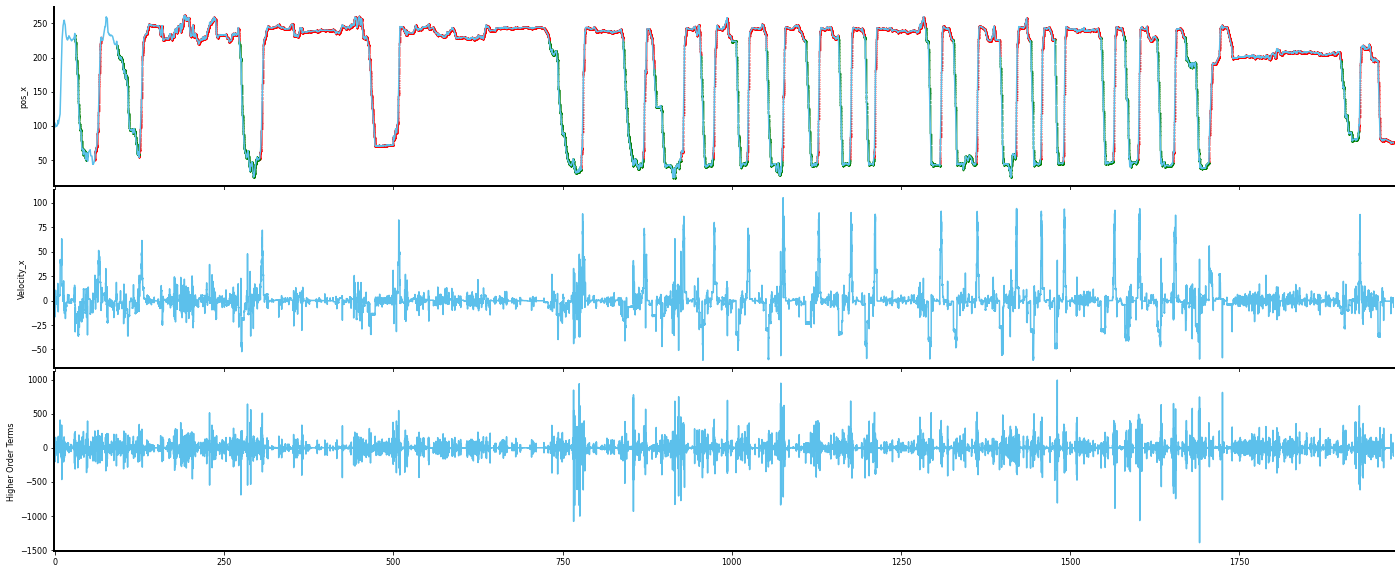

In [167]:
figsize=(24, 10)
subplots=(3, 1)
fig = plt.figure(figsize=figsize, clear=True)
gs = plt.GridSpec(subplots[0], subplots[1], figure=fig, hspace=0.02)
# fig.subplots_adjust(hspace=0.4)
# position_obj = active_epoch_session.position

ax0 = fig.add_subplot(gs[0])
# ax0.plot(position_obj.time, position_obj.linear_pos)
# ax0.set_ylabel('linear_pos')
ax0.plot(position_obj.time, position_obj.x)
ax0.set_ylabel('pos_x')


ax1 = fig.add_subplot(gs[1])
ax1.plot(position_obj.time, pos_df['velocity_x'])
ax1.set_ylabel('Velocity_x')



ax2 = fig.add_subplot(gs[2])
# ax2.plot(position_obj.time, position_obj.velocity)
# ax2.plot(position_obj.time, pos_df['velocity_x'])
ax2.plot(position_obj.time, pos_df['acceleration_x'])
# ax2.plot(position_obj.time, pos_df['velocity_y'])
ax2.set_ylabel('Higher Order Terms')


# Shared:
ax0.get_shared_x_axes().join(ax0, ax1, ax2)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax0.set_xlim([position_obj.time[0], position_obj.time[-1]])

## Constain to a specific lap:
curr_lap_times = sess.laps.get_lap_times(2)
# ax0.set_xlim([curr_lap_times[0], curr_lap_times[-1]])

# unique_lap_values
# curr_lap_i = 2
# curr_lap_points = lap_grouped_pos_dfs[curr_lap_i][['t','x']].to_numpy()
# # curr_lap_num_points = curr_lap_num_points[curr_lap_i]
# assert np.shape(curr_lap_points)[1] == 2, 'curr_lap_points must be in the form [numPoints x 2], where 2 is the x and y components'
# np.shape(curr_lap_points) # (961, 2)

# num_points = np.shape(curr_lap_points)[0]
# # test_points = make_segments(curr_lap_points[:,0], curr_lap_points[:,1]) # (960, 2, 2). (0, 1922, 2)
# test_points = curr_lap_points.reshape(-1, num_points, 2) # (1, 961, 2)


# print(np.shape(test_points)) # (960, 2, 2). 

# # ax0.plot(curr_lap_points[:,0], curr_lap_points[:,1], 'r')

# # segments = np.concatenate([test_points[:-1], test_points[1:]], axis=1)
# # np.shape(segments)
# # lc = mcoll.LineCollection(segments, cmap=plt.get_cmap('jet'), linewidth=5)
# # ax0.add_collection(lc)

curr_lap_dir_i = 1;

# curr_lap_dir_points = lap_dir_grouped_pos_dfs[curr_lap_dir_i][['t','x']].to_numpy()
curr_even_lap_dir_points = pd.concat(lap_grouped_pos_dfs[is_even_lap])[['t','x']].to_numpy()
ax0.scatter(curr_even_lap_dir_points[:,0], curr_even_lap_dir_points[:,1], s=0.5, c='r')

curr_odd_lap_dir_points = pd.concat(lap_grouped_pos_dfs[is_odd_lap])[['t','x']].to_numpy()
ax0.scatter(curr_odd_lap_dir_points[:,0], curr_odd_lap_dir_points[:,1], s=0.5, c='g')
# ax0.plot(curr_odd_lap_dir_points[:,0], curr_odd_lap_dir_points[:,1], 'g')


# plt.link_axes([ax0, ax1, ax2])
# plt.plot
# active_epoch_placefields2D.t
# active_epoch_placefields2D.x
# plt.gca()
# np.isin(active_epoch_placefields2D.t, 
# y3 = np.ma.masked_where(y > 0.7, y)

In [ ]:
active_epoch_placefields2D.plotMap(figsize=(12,20), enable_spike_overlay=True)

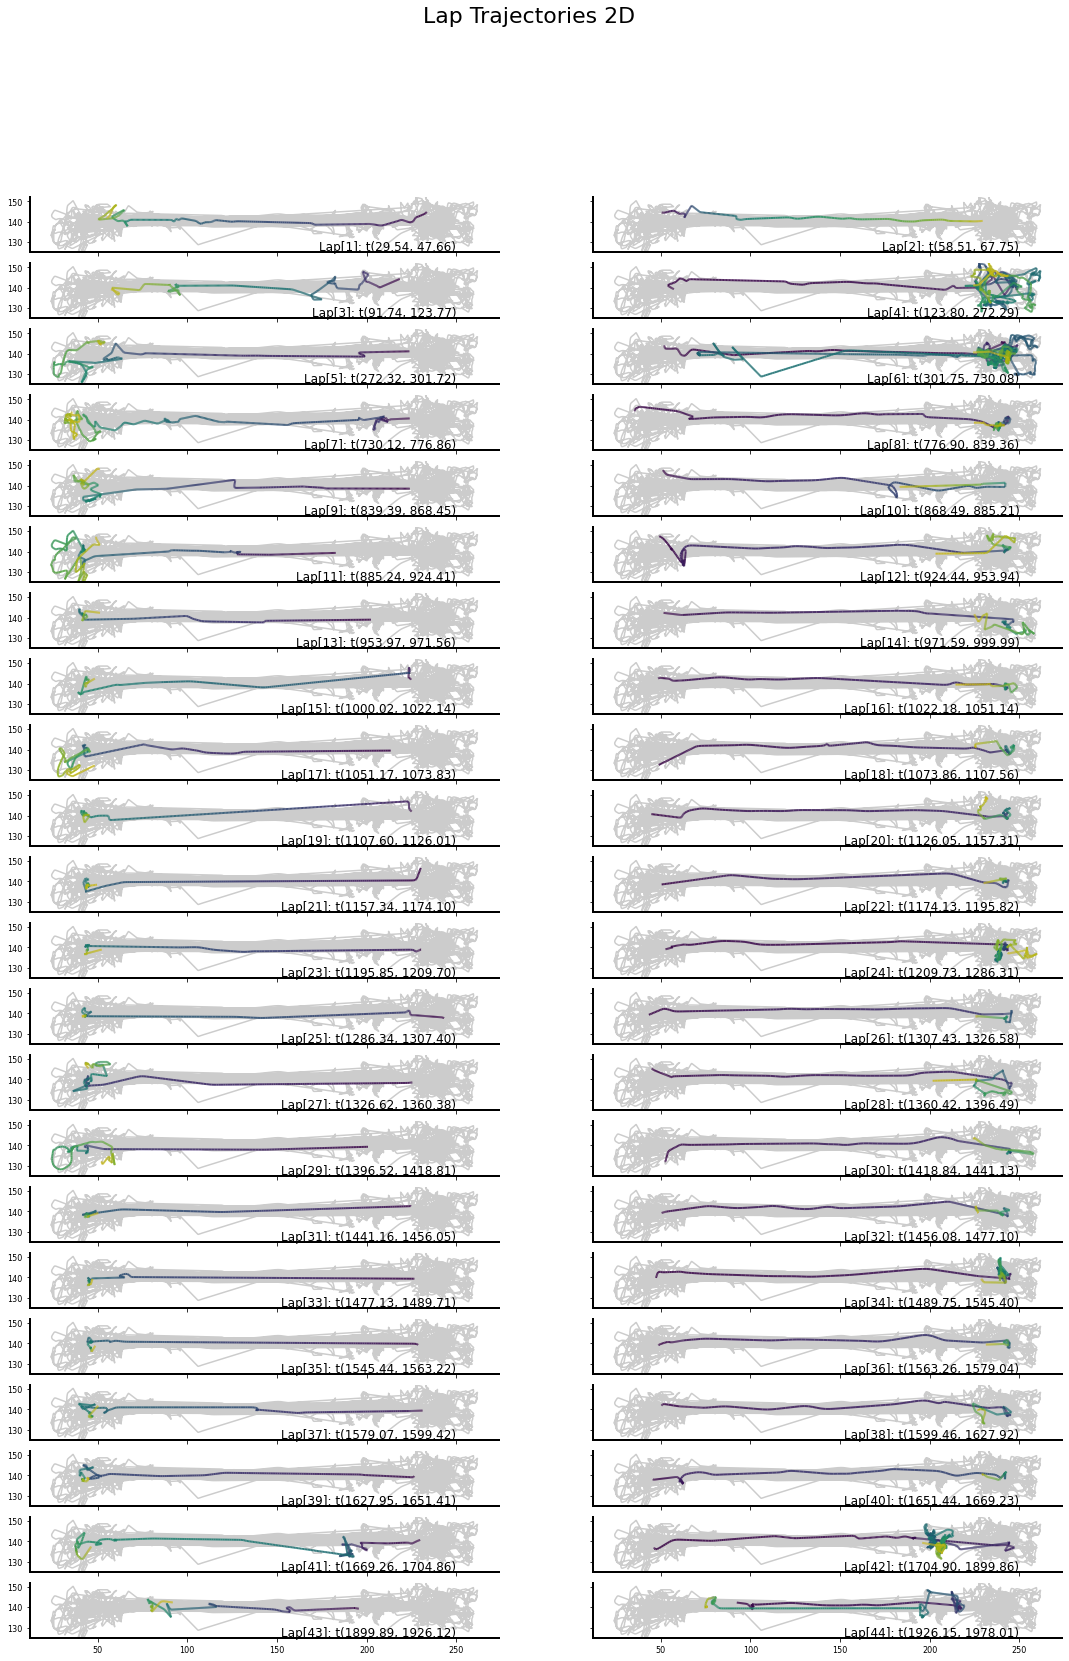

In [19]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
fig, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=len(sess.laps.lap_id), active_page_index=0)
fig.suptitle('Lap Trajectories 2D', fontsize=22)
# fig_out_path = active_config.plotting_config.get_figure_save_path('lap_trajectories_2D').with_suffix('.png')
# fig.savefig(fig_out_path)
plt.show()

# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=0)
# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=1)

# 3D Plots

### 3D Lap Trajectories Visualization:

In [20]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
p, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=10, active_page_index=1)
p.show()

## Tuning Curves 3D Plot:

In [ ]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, active_config.plotting_config.pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

### Tuning-Curve Height Spikes Plot Testing:

In [ ]:
from matplotlib.collections import EventCollection
from scipy.interpolate import RectBivariateSpline # for 2D spline interpolation

## Getting the proper z-position for the tuning curve:
# Create source to ray trace
sphere = pv.Sphere(radius=0.85)

# Define a list of origin points and a list of direction vectors for each ray
# vectors = [ [cos(radians(x)), sin(radians(x)), 0] for x in range(0, 360, 5)]

# origins = [[0, 0, 0]] * len(active_lap_specific_epoch_session.spikes_df['x'])
# origins = np.hstack(active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T, np.full_like(active_lap_specific_epoch_session.spikes_df['x'].to_numpy(), 0.0))
# origins[0,:]
# spike_series_identities = active_flattened_spike_identities # currently unused

active_epoch_placefields2D


active_epoch_placefields1D.ratemap_spiketrains # times where the spikes occured.
active_epoch_placefields1D.ratemap_spiketrains_pos # position where the spikes occured.

## This is the correct 1D interpolation! It gets the y-values on the curve where the spikes could be plot!
spike_pf_heights_1D = [np.interp(active_epoch_placefields1D.spk_pos[i], active_epoch_placefields1D.ratemap.xbin_centers, active_epoch_placefields1D.ratemap.normalized_tuning_curves[i]) for i in np.arange(active_epoch_placefields1D.ratemap.n_neurons)] # the appropriately interpolated values for where the spikes should be on the tuning_curve

## Potentially successfully implemented the z-interpolation!!!: 2D interpolation where the (x,y) point of each spike is evaluated to determine the Z-position it would correspond to on the pf map.
_spike_pf_heights_2D_splineAproximator = [RectBivariateSpline(active_epoch_placefields2D.ratemap.xbin_centers, active_epoch_placefields2D.ratemap.ybin_centers, active_epoch_placefields2D.ratemap.normalized_tuning_curves[i]) for i in np.arange(active_epoch_placefields2D.ratemap.n_neurons)] 
spike_pf_heights_2D = [spike_pf_heights_2D_splineAproximator[i](active_epoch_placefields2D.spk_pos[i][0], active_epoch_placefields2D.spk_pos[i][1], grid=False) for i in np.arange(active_epoch_placefields1D.ratemap.n_neurons)] # the appropriately interpolated values for where the spikes should be on the tuning_curve
print(f'np.shape(spike_pf_heights_2D): {np.shape(spike_pf_heights_2D[i])}') # (809,)

#spike_pf_heights_1D is (814,) and the values range between 0.0 and 1.0

fig = plt.Figure()
axes = fig.subplots(3, 1, sharex=True)
axes[0].plot(active_epoch_placefields1D.ratemap.xbin_centers, active_epoch_placefields1D.ratemap.normalized_tuning_curves[i])
axes[0].set_ylabel('norm_tuning_curve')
# axes[0].plot(active_epoch_placefields1D.ratemap.xbin_centers, active_epoch_placefields1D.ratemap.normalized_tuning_curves[i])
# plt.plot(active_epoch_placefields1D.spk_pos[i])
# plt.plot(active_epoch_placefields1D.spk_t[i], spike_pf_heights_1D[i])

axes[1].scatter(active_epoch_placefields1D.spk_pos[i], spike_pf_heights_1D[i])
axes[1].set_ylabel('spike_pf_heights')

# # create the events marking the x data points
# xevents1 = EventCollection(xdata1, color='tab:blue', linelength=0.05)
# xevents2 = EventCollection(xdata2, color='tab:orange', linelength=0.05)

# # create the events marking the y data points
# yevents1 = EventCollection(ydata1, color='tab:blue', linelength=0.05,
#                            orientation='vertical')
# yevents2 = EventCollection(ydata2, color='tab:orange', linelength=0.05,
#                            orientation='vertical')

# # add the events to the axis
# ax.add_collection(xevents1)
# ax.add_collection(xevents2)
# ax.add_collection(yevents1)
# ax.add_collection(yevents2)

fig

In [ ]:
active_epoch_session.position

vectors = [[0, 0, 10.0]] * len(active_lap_specific_epoch_session.spikes_df['x']) # just up in the z-direction
spike_series_positions = active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T    
z_fixed = np.full_like(spike_series_positions[0,:], 1.1) # Offset a little bit in the z-direction so we can see it
origins = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z_fixed)).T
# origins

# Perform ray trace
# Define line segment
# start = [0, 0, 0]
# stop = [0.25, 1, 0.5]

curr_idx = 0
curr_tuning_curve_mesh = ipcDataExplorer.plots['tuningCurvePlotActors'][curr_idx]
start = origins[curr_idx]
stop = start + vectors[curr_idx]

# Perform ray trace
# points, ind = sphere.ray_trace(start, stop)
points, ind = curr_tuning_curve_mesh.ray_trace(start, stop)
pActiveTuningCurvesPlotter.add_mesh(ray, color="blue", line_width=5, name='test_ray', label="Ray Segment")
pActiveTuningCurvesPlotter.add_mesh(intersection, color="maroon",
           point_size=25, label="Intersection Points", name='test_ray_intersection')
# points, ind_ray, ind_tri = sphere.multi_ray_trace(origins, vectors)

## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

## CustomDataExplorer 3D Plotter:

In [ ]:
from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
active_laps_config = InteractivePlaceCellConfig(active_session_config=sess.config, active_epochs=None, video_output_config=None, plotting_config=None) # '3|1    
active_laps_config.plotting_config = PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', sess.config.session_name, 'custom_laps'))

try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer = InteractiveCustomDataExplorer(active_laps_config, sess, extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=pActiveInteractiveLapsPlotter)

In [ ]:
len(sess.laps.lap_id) # 44

In [ ]:
for i in np.arange(len(sess.laps.lap_id)):
    curr_lap_id = sess.laps.lap_id[i]
    curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    curr_lap_position_traces = laps_position_traces[i]
    plot_lap_trajectory_path_spline(iplapsDataExplorer, curr_lap_position_traces, curr_lap_id)

In [ ]:
# p = pv.Plotter(shape=(5, 1), border=True)
p = pActiveInteractiveLapsPlotter
num_laps_to_show = len(sess.laps.lap_id)
num_laps_to_show = 5
flat_lap_id_index = np.arange(len(sess.laps.lap_id))
# subplot_lap_id_index = np.reshape([4,11])
for i in np.arange(num_laps_to_show):
    curr_lap_id = sess.laps.lap_id[i]
    p.subplot(i, 0)
    # curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    plot_lap_trajectory_path_spline(iplapsDataExplorer, laps_position_traces[i], curr_lap_id)
    
p.link_views()  # link all the views
p.show()

In [ ]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
# print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 
# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
# print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


In [ ]:
## Timestamp Fixing:
def tt(position_timestamps, t_begin, SampleRate):
    return ((position_timestamps - t_begin) / (1e6 * SampleRate))

# sess.laps.lap_start_stop_flat_idx

sess.recinfo.dat_sampling_rate


# Programmatically change the animal position trail:

In [ ]:
curr_lap_id = int_input.value

# plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
plot_lap_trajectory_path_spline(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showding/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [ ]:
# From the laps and position dataframe, extract which lap every position belongs to:

# curr_lap_position_df_is_included = curr_position_df['t'].between(laps_df['start'], laps_df['stop'], inclusive=True) # returns a boolean array indicating inclusion in teh current lap
# curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
# curr_position_df['lap'] = np.NaN

curr_position_df = sess.compute_position_laps()
# curr_position_df.groupby('lap').groups[1] # returns the Int64Index
# curr_position_df.groupby('lap').get_group(2)[['t','x','y','lin_pos']]

lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id]
lap_specific_position_dfs
curr_lap_position_traces = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
curr_lap_position_traces
curr_lap_time_range = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]
curr_lap_time_range

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_point

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice

In [ ]:
## Adding interaction highlighters:
pActiveInteractivePlaceSpikesPlotter.